# Binding energy calculation

## Justification

For two interacting RNAs, their binding energy and thus likelihood of interacting may be found through a variety of RNA simulators. In practice, this binding energy $\Delta G$ may translate into actual binding and subsequent repression in a genetic circuit through the forward and reverse equilibrium rates of the reaction. Both of these will vary based on the RNA, so we have chosen to parameterise the RNA binding from existing data using the research paper ["Metabolic engineering of Escherichia coli using synthetic small regulatory RNAs" (2013)](https://www.nature.com/articles/nbt.2461#Fig1). A sigmoid function was fit to data of RNA binding energy vs. fluorescence, which was used as a proxy for measuring repression efficiency. 

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('dark_background')
import numpy as np

Creating the parameterisation function of the data (have gone with an estimation approach as the data reported in the paper is insufficient, but have requested it and hopefully can re-parameterise in future).

Using the following points as guidelines:
- -3kcal $\approx$ 1 F
- -10kcal $\approx$ 0.5 F
- -22kcal $\approx$ 0.1 Fluorescence
- -37kcal $\approx$ 0.01 F

Fluorescence is at the 50% point at (kcal): 
-10.0

At -3kcal:  0.9709808915561572

At -10kcal:  0.505

At -22kcal:  0.012447896925068426

At -38kcal:  0.01000135724763479


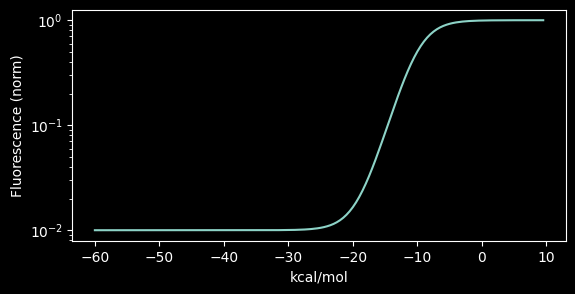

In [26]:
def cal_to_j(E_cal):
    return E_cal * 4.184


def j_to_cal(E_j):
    return E_j / 4.184


def binding_energy_sigmoid(E):
    """ The binding energy is in units of kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F


def binding_energy_sigmoid_J(E):
    """ The binding energy is in units of kJ/mol """
    F = (1-0.01)/(1+np.exp(-(E/8.368 + 5))) + 0.01
    return F


E = np.arange(-60, 10, 0.5)

plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.plot(
    E,
    binding_energy_sigmoid(E)
)
plt.xlabel('kcal/mol')
plt.ylabel('Fluorescence (norm)')
plt.yscale('log')


print('Fluorescence is at the 50% point at (kcal): ')
print(E[np.argmax(binding_energy_sigmoid(E) >= 0.5)])

print('\nAt -3kcal: ', binding_energy_sigmoid(-3))
print('\nAt -10kcal: ', binding_energy_sigmoid(-10))
print('\nAt -22kcal: ', binding_energy_sigmoid(-22))
print('\nAt -38kcal: ', binding_energy_sigmoid(-37))


Now we need to relate the fluorescence to the equilibrium rates. We have previously derived an approximation for this in the following manner, where $F = $ fluorescence, $D = $ free DNA, $S = $ sRNA, $SD = $ bound DNA, $k_a = $ association rate, $k_d = $ dissociation rate, and $K = $ equilibrium constant:

$$F = \frac{[D]}{([D] + [SD])} $$
$$\frac{1}{F} - 1 = \frac{[SD]}{[D]}$$

We already know the equilibrium constant from $\Delta G$:

$$K = e^{- \Delta G / RT} = \frac{k_a}{k_d} = \frac{[Product]}{[Reactants]} = \frac{[SD]}{[S][D]}$$

We also know that for different fluorescences, different forward and reverse rates must be in play.

$$F = 1 \to k_d >> k_a $$
$$F = 0.001 \to k_d << k_a $$
$$F = 0.5 \to [D] = [SD] \to \frac{k_a}{k_d} = \frac{[SD]}{[S][D]} \approx \frac{1}{[S]} $$
$$F = 0.25 \to [D] = 3[SD] \to \frac{k_a}{k_d} = \frac{3[SD]}{[S][D]} \approx \frac{3}{[S]} $$

$$\frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1}{F} - 1 \big) $$

In the code above, we have fit a sigmoid curve to the data in the research paper. This fit curve gives

$$F(\Delta G) \approx \frac{1 - 0.01}{1 + e^{-(\Delta G / 12.552 + 5)}} + 0.01 $$

If we expand this out and make fluorescence dependent on the minimum free energy of binding \Delta G:

$$K = \frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1 - 0.01}{\frac{1}{1 + e^{-(\Delta G / 12.552 + 5)}} + 0.01} - 1 \big) $$

Since we have also estimated a constant value for association constant $k_a$, this would be used to find the dissociation constant. The only question is what to do with the S term in the final equation. Since we know that at half the normalised fluorescence $F = 0.5$, the equilibrium constant should be equal to 1 ($K = 1$), as the ratio of bound to unbound species should be 1. From this, we can find the concentration $[S]$ that fulfills the equation.


Text(0.5, 1.0, 'k_d, [S] = 0.98mol')

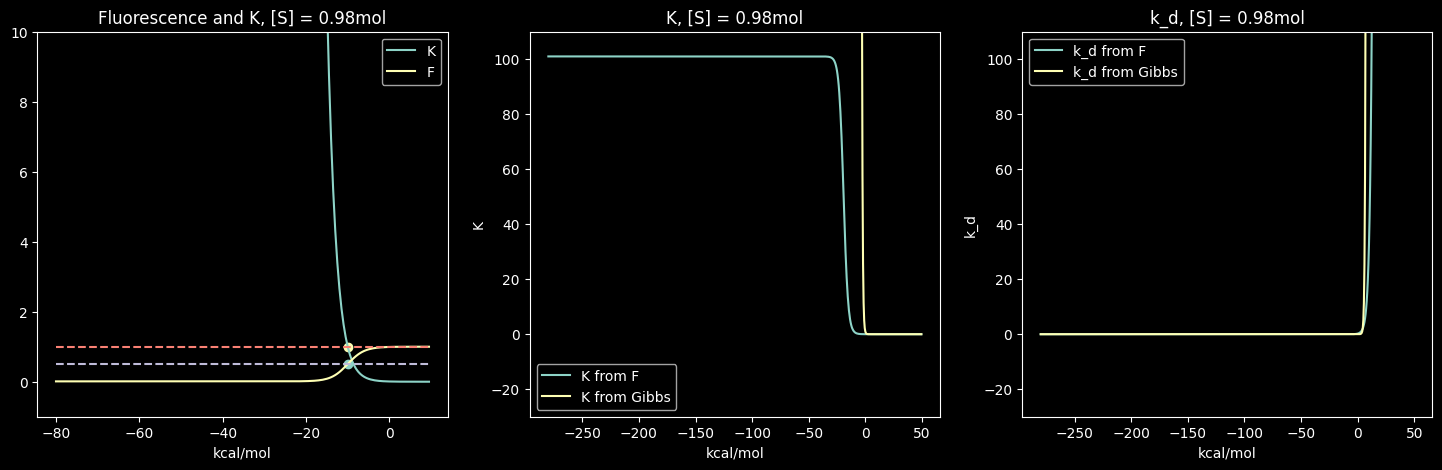

In [27]:
def F(E):
    """ kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F
    # return 1/(1+np.exp(-(E/3 + 5))) + 0.01


def gibbs_K_cal(E):
    """ In kcal/mol. dG = - RT ln(K) """
    RT = 1.987 * 310
    E = E * 1000
    K = np.exp(-E/(RT))
    return K


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kcal/mol """
    return 1/initial * (1/F(E) - 1)


E = np.arange(-80, 10, 0.5)
E_F_half = E[np.argmax(F(E) >= 0.5)]
initial = np.round(1/1 * (1/F(E_F_half) - 1), 2)
k_a = 0.0015


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(
    E,
    equilibrium_constant_fluorescence(E, initial),
    label='K'
)
plt.xlabel('kcal/mol')
# plt.yscale('log')
plt.plot(
    E,
    F(E),
    label='F'
)
plt.scatter(E_F_half, F(E_F_half))
plt.scatter(E_F_half, equilibrium_constant_fluorescence(E_F_half, initial))
plt.plot(E, np.ones_like(E) * F(E_F_half), '--')
plt.plot(E, np.ones_like(E) * equilibrium_constant_fluorescence(E_F_half, initial), '--')
plt.ylim(-1, 10)
plt.legend()
plt.title(f'Fluorescence and K, [S] = {initial}mol')

ax = plt.subplot(1, 3, 2)
E2 = np.arange(-280, 50, 0.5)
plt.plot(E2, equilibrium_constant_fluorescence(E2, initial), label='K from F')
plt.plot(E2, gibbs_K_cal(E2), label='K from Gibbs')
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.ylim(-30, 110)
plt.title(f'K, [S] = {initial}mol')

ax = plt.subplot(1, 3, 3)
plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, initial), label='k_d from F')
plt.plot(E2, k_a/gibbs_K_cal(E2), label='k_d from Gibbs')
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.ylim(-30, 110)
plt.title(f'k_d, [S] = {initial}mol')




In this case, $[S]$ turned out to be roughly equal to 1 mol for the $\Delta G$ where F = 0.5 the same as that for making $K = 1$, which turned out to be roughly around $\Delta G = - 10$ kcal/mol.
For comparison, the original equation for K and $\Delta G$ is plotted as well and shows a much faster increase past 1, around -1 kcal/mol.

Text(0.5, 1.0, 'k_d from Gibbs, k_a = 0.0015')

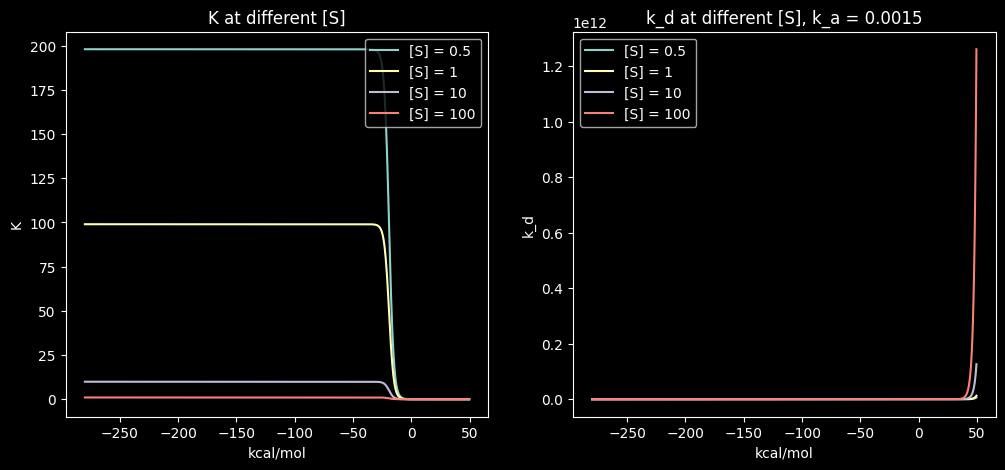

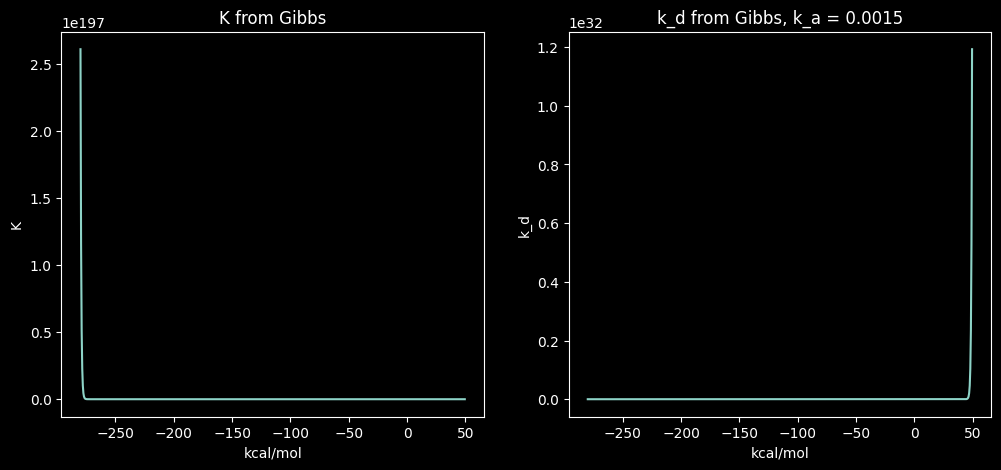

In [28]:
S = [0.5, 1, 10, 100]

plt.figure(figsize=(12, 5))
for s in S:
    ax = plt.subplot(1,2,1)
    plt.plot(E2, equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')
    ax = plt.subplot(1,2,2)
    plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')

ax = plt.subplot(1,2,1)
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.title('K at different [S]')

ax = plt.subplot(1,2,2)
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.title(f'k_d at different [S], k_a = {k_a}')


# Comparison to Gibbs
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.plot(E2, gibbs_K_cal(E2))
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.title('K from Gibbs')

ax = plt.subplot(1,2,2)
plt.plot(E2, k_a/gibbs_K_cal(E2))
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.title(f'k_d from Gibbs, k_a = {k_a}')



In [29]:
K_G = gibbs_K_cal(E2)
K_F = equilibrium_constant_fluorescence(E2, initial)
print('dG at which K from Gibbs is 1:\t\t\t', E2[np.argmax(K_G <= 1)])
print('dG at which K from Fluorescence is 1:\t\t',E2[np.argmax(K_F <= 1)])

print('K from Gibbs at -100 kcal:\t\t\t', gibbs_K_cal(-100))
print('K from Fluorescence at -100 kcal:\t\t\t', equilibrium_constant_fluorescence(-100, initial))


dG at which K from Gibbs is 1:			 0.0
dG at which K from Fluorescence is 1:		 -9.5
K from Gibbs at -100 kcal:			 3.204680085638281e+70
K from Fluorescence at -100 kcal:			 101.0204081632653


From above calculations, the $\Delta G$ at which K is equal to 1 is $\Delta G = 0 $ kcal for K derived from the Gibbs equation, while for the K derived from the fitted fluorescence curve it is $\Delta G \approx -10 $ kcal. It now takes a more negative $\Delta G$ for the equilibrium constant to reach a balance between forward and reverse reaction rates. This means that circuit components must interact much more strongly to be considered binding.

At the same time, the K derived from fluorescence increases more quickly once it is past the $K = 1$, meaning that as soon as any RNA is binding strongly enough, it will bind much more strongly that from the Gibbs free energy case. Therefore, the new energy approximation curve will be biased against RNAs that bind in the intermediate range.

## Tests

Get outer level imports first...

In [10]:
import os
import sys

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from copy import deepcopy
from tests.shared import five_circuits, CONFIG
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller

config = deepcopy(CONFIG)

Initialise circuits, then change the equilibrium constants and binding rates of dissociation to pull from the fluorescence-based approximation of binding.

In [11]:
circuits, config, data_writer = five_circuits(
    config, data_writer=None)



In [12]:
def init_circuits(circuits):
    circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "init_circuit": {}
            # "simulate_signal_batch": {'ref_circuit': None,
            #                           'batch': config['simulation']['use_batch_mutations']},
            # "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
            #                   'no_numerical': config['experiment']['no_numerical']}
        })
    return circuits

In [9]:
circuits = init_circuits(circuits)

Projected time: 3.3210369999999996s 
Total time: 0:00:03.321062


In [13]:
def transform_rates(circuits):
    for i in range(len(circuits)):
        circuits[i].interactions.eqconstants = equilibrium_constant_fluorescence(circuits[i].interactions.energies, initial)
        circuits[i].interactions.binding_rates_dissociation = circuits[i].interactions.binding_rates_association / circuits[i].interactions.eqconstants
    return circuits


In [11]:
circuits = transform_rates(circuits)


NameError: name 'xx' is not defined

In [14]:
config['signal']['function_kwargs']['target'] = 0.5
config['simulation']['t1'] = 1500
config['simulation']['dt'] = 0.01

def sim_write(circuits):
    circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            # "init_circuit": {}
            "simulate_signal_batch": {'ref_circuit': None,
                                    'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                            'no_numerical': config['experiment']['no_numerical']}
        })
    return circuits



In [ ]:
circuits = sim_write(circuits)

In [15]:

def vis_sim(circuits):
    output_files = pd.concat([
        pd.read_csv(os.path.join(data_writer.write_dir, c.name, 'output_summary.csv')) for c in circuits
    ], axis=0)

    from IPython.display import SVG, display
    x = output_files[(output_files['out_type'] == 'svg') & (output_files['name'] == 'signal')]
    for out_path, subdir in zip(x['out_path'], x['subdir']):
        print(subdir)
        display(SVG(filename=out_path))

In [ ]:
vis_sim(circuits)

## Find circuit with adaptation abilities

In [16]:
from src.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from src.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols
from src.utils.common.setup_new import construct_circuit_from_cfg
from src.srv.sequence_exploration.sequence_analysis import pull_circuits_from_stats

In [ ]:
stats_pathname = '../data/ensemble_generate_circuits/2023_02_23_174630/gather_interaction_stats/circuit_stats.csv'
circuit_specs = pull_circuits_from_stats(filters={
    "min_num_interacting": 3,
    "max_self_interacting": None,
    "max_total": 30
}, stats_pathname=stats_pathname)

strong_circuits = [construct_circuit_from_cfg(
    c, config_file=config) for c in circuit_specs]


### Statistics of randomly generated circuits

Below are some stats on a batch of 20000 circuits that were generated randomly, albeit from a distribution of RNA nucleotides where each had a probability weighting corresponding to its abundance in the E. coli genome. Species are considered interacting if the equilibrium constant is greater than 1. Something that becomes obvious when grouping the binding energies by the number of interacting and self-interacting RNA species is that
- only 25/20000 = 0.125% circuits have 3 interactions (between different species)
- self-interacting species do not reach as negative binding energies
- the stronger the binding energy, the more nucleotides are bound together
- the most negative binding energy (ca. -9kcal/mol) corresponds to an equilibrium constant (ca. 0.01) from the fluorescence parameterisation that is still well below $K = 1$, meaning that if the criteria for species interacting were based on this new equilibrium constant, none of the circuits would be considered interacting. Perhaps 

In [ ]:
stats = pd.read_csv(stats_pathname)

In [ ]:

def undo_bplist(bp):
    return np.array([[int(i) for i in p.replace('(', '').replace(')', '').replace('nan', '0').split(',')] for p in str(bp).split(':')])


In [ ]:
for c in stats.columns:
    if 'binding_sites_' in c and not (('counts' in c) or ('bindratio' in c)):
        stats[c + '_counts'] = stats[c].apply(str).apply(
            lambda x: len(x.split('nan')[0].split(':')) - (x == 'nan'))
        stats[c + '_bindratio'] = stats[c].apply(str).apply(
            lambda x: (undo_bplist(x).T[0, -1] - undo_bplist(x).T[0, 0]) / (len(undo_bplist(x)) - 1))

aggd = {c: 'mean'
        for c in stats.columns if ('binding_sites_' in c) and (('_counts' in c) or ('_bindratio' in c))}
aggd.update({c: ['mean',
                 lambda x: equilibrium_constant_fluorescence(np.mean(x), initial)]
             for c in stats.columns if 'energies_' in c})

stats.groupby(['num_interacting', 'num_self_interacting'], as_index=False).agg(aggd)
# .rename(columns={'<lambda_0>': 'mean_K-from-F'})


num_interacting num_self_interacting binding_sites_0-0_counts  \
                                                            mean   
0                0                    0                 0.000000   
1                0                    1                 3.184289   
2                0                    2                 6.612723   
3                0                    3                 9.983333   
4                1                    0                 0.000000   
5                1                    1                 3.272944   
6                1                    2                 6.459610   
7                1                    3                11.533333   
8                2                    0                 0.000000   
9                2                    1                 3.399123   
10               2                    2                 6.509804   
11               2                    3                11.200000   
12               3                    0                 0.000000   
13               3                    1                 3.200000   
14               3                    2                 7.600000   

   binding_sites_0-0_bindratio binding_sites_0-1_counts  \
                          mean                     mean   
0                          NaN                 0.000000   
1                     1.037888                 0.000000   
2                     1.037220                 0.000000   
3                     1.036181                 0.000000   
4                          NaN                 3.141376   
5                     1.036111                 3.252086   
6                     1.041103                 3.247911   
7                     1.077980                 1.733333   
8                          NaN                 6.054487   
9                     1.057952                 5.846491   
10                    1.055272                 6.470588   
11                    1.090630                 5.300000   
12                         NaN                 9.300000   
13                    1.000000                 9.300000   
14                    1.000000                 7.800000   

   binding_sites_0-1_bindratio binding_sites_0-2_counts  \
                          mean                     mean   
0                          NaN                 0.000000   
1                          NaN                 0.000000   
2                          NaN                 0.000000   
3                          NaN                 0.000000   
4                     1.118416                 3.022388   
5                     1.127583                 3.160906   
6                     1.104578                 3.167131   
7                     1.142857                 3.733333   
8                     1.112952                 6.496795   
9                     1.129649                 6.140351   
10                    1.107683                 5.960784   
11                    1.037037                 6.700000   
12                    1.149722                10.100000   
13                    1.118838                 9.600000   
14                    1.028571                10.600000   

   binding_sites_0-2_bindratio binding_sites_1-0_counts  \
                          mean                     mean   
0                          NaN                 0.000000   
1                          NaN                 0.000000   
2                          NaN                 0.000000   
3                          NaN                 0.000000   
4                     1.112741                 3.141376   
5                     1.122671                 3.252086   
6                     1.121526                 3.247911   
7                     1.193107                 1.733333   
8                     1.112528                 6.054487   
9                     1.113741                 5.846491   
10                    1.127448                 6.470588   
11                    1.067821                 5.300000   
12          

The following plots may be a bit misleading, as they appear to maintain the true spread of each of the features, but this is not the case - each stacked bar plot is adding up the blocks together, so a bar going from 0-100 with 5 blocks would mean each block has a value of around 20, while a bar that spans across 0 has blocks with negative values added together. The purpose is to show the rough length of each block, as well as highlighting differences between the spans of blocks at different numbers of interaction. For example, self-interactions tend to have a larger variance. The new equilibrium constant also has a smaller set of means compared to the original Gibbs equation K, for which a $\Delta G$ of 30kcal was given if the RNA simulator did not predict any binding.

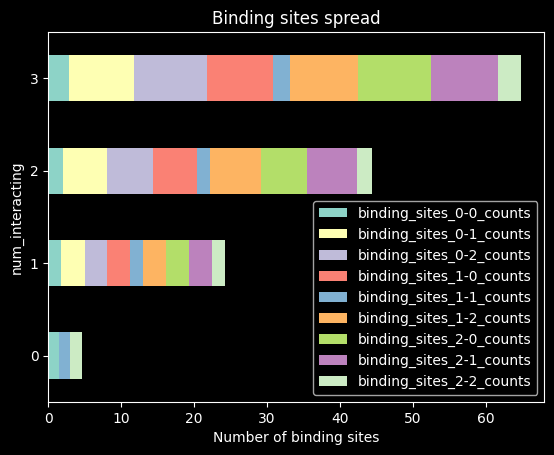

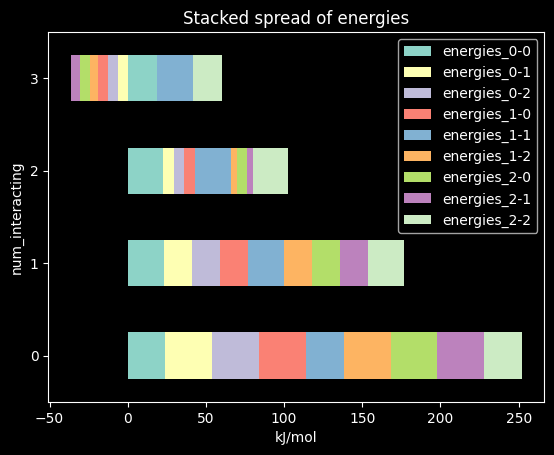

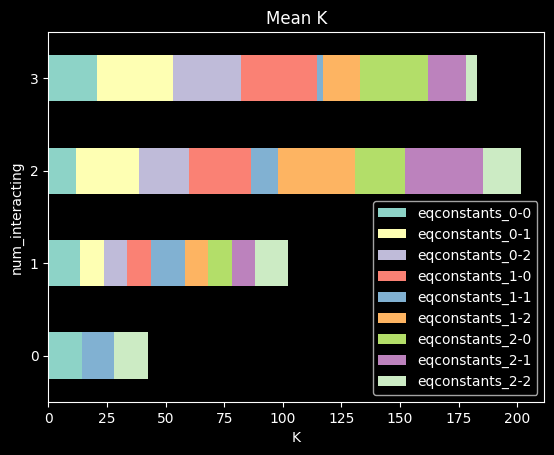

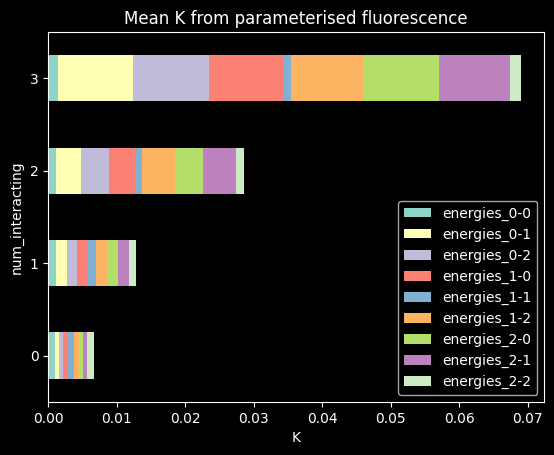

In [ ]:

aggd = {c: 'mean'
        for c in stats.columns if ('binding_sites_' in c) and ('_counts' in c)}

stats.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Binding sites spread',
    mark_right=True)
plt.xlabel('Number of binding sites')
plt.show()

aggd = {c: 'mean'
        for c in stats.columns if 'energies_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Stacked spread of energies',
    mark_right=True)
plt.xlabel('kcal/mol')
plt.show()
plt.close()

aggd = {c: 'mean'
        for c in stats.columns if 'eqconstants_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Mean K',
    mark_right=True)
plt.xlabel('K')
plt.show()
plt.close()

aggd = {c: lambda x: equilibrium_constant_fluorescence(np.mean(x), initial)
        for c in stats.columns if 'energies_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd).rename(columns={'<lambda_0': 'mean_K-from-F'}).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Mean K from parameterised fluorescence',
    mark_right=True)
plt.xlabel('K')
plt.show()
plt.close()


In [ ]:
aggd = {c: 'mean'
        for c in stats.columns if 'energies_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd)

,num_interacting,energies_0-0,energies_0-1,energies_0-2,energies_1-0,energies_1-1,energies_1-2,energies_2-0,energies_2-1,energies_2-2
0,0,24.076955,30.000000,30.000000,30.000000,23.984909,30.000000,30.000000,30.000000,23.928858
1,1,23.090733,17.805482,18.082670,17.805482,23.070694,17.882211,18.082670,17.882211,23.032930
2,2,22.293561,7.385358,6.146206,7.385358,22.936090,4.040599,6.146206,4.040599,22.136423
3,3,18.940800,-6.185200,-6.385600,-6.185200,22.942000,-5.613200,-6.385600,-5.613200,18.490400


In [ ]:
len(strong_circuits)

25

In [ ]:
config['signal']['function_kwargs']['target'] = 0.5
config['simulation']['t1'] = 7500
config['simulation']['dt'] = 0.01

strong_circuits = init_circuits(strong_circuits)
# strong_circuits = transform_rates(strong_circuits)
strong_circuits = sim_write(strong_circuits)
# vis_sim(strong_circuits)



circuit_manager_new.py:prepare_internal_funcs():379: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager_new.py:batch_circuits():442: 	From 25 circuits, a total of 25 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():449: 		Starting new round of viable circuits (0 - 25 / 25) WARNING
circuit_manager_new.py:batch_circuits():467: 		Making subcircuits 0 - 25 took 3.8e-05s WARNING
circuit_manager_new.py:batch_circuits():473: 	Batching 0 - 100 circuits (out of 0 - 25 (total: 25)) (Circuits: 0 - 25 of 25) WARNING
circuit_manager_new.py:run_batch():504: 		Running 25 Subcircuits - toy_mRNA_circuit_10652: init_circuit WARNING
circuit_manager_new.py:run_batch():540: 		Method init_circuit took 1.067782s WARNING
circuit_manager_new.py:batch_circuits():487: Single batch: 0:00:01.069191 
Projected time: 1.069191s 
Total time: 0:00:01.069205 WARNING
circuit_manager_new.py:prepare_internal_funcs():379: Signal differs betw

In [ ]:
info = b_tabulate_mutation_info(data_writer.ensemble_write_dir,
                                data_writer=data_writer, experiment_config=config)


In [ ]:
output_species = 'RNA_1'
output_idx = [s.name for s in circuits[0].model.species].index(output_species)

analytics_cols = get_true_names_analytics(strong_circuits[0].result_collector.get_result('signal').analytics)
[c for c in analytics_cols if 'sensitivity' in c]


['sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_diff_to_base_circuit',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base']

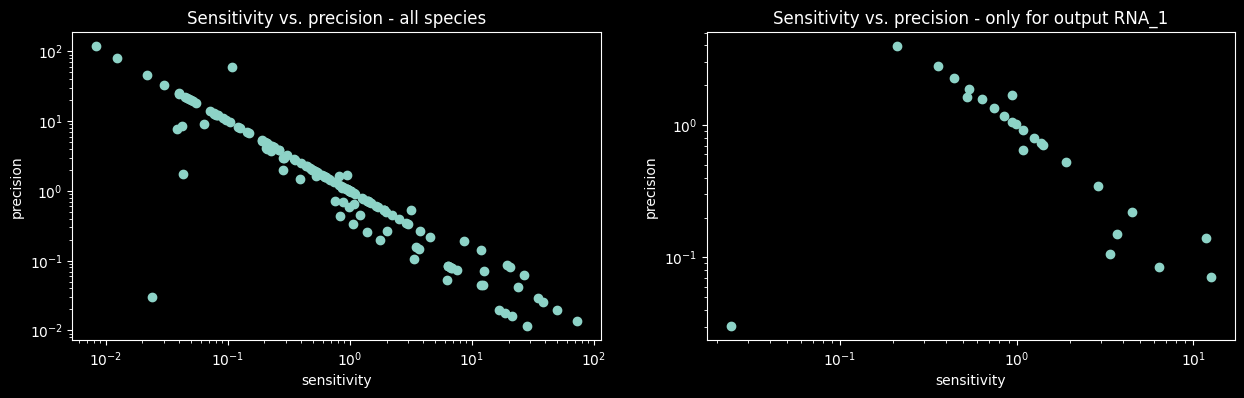

In [ ]:
sig_analytics = [strong_circuits[i].result_collector.get_result('signal').analytics for i in range(len(strong_circuits))]

plt.figure(figsize=(15, 4))
ax = plt.subplot(1,2,1)
plt.scatter(x=[s['sensitivity_wrt_species-6'] for s in sig_analytics],
            y=[s['precision_wrt_species-6'] for s in sig_analytics])
plt.xlabel('sensitivity')
plt.ylabel('precision')
plt.title('Sensitivity vs. precision - all species')
plt.xscale('log')
plt.yscale('log')

ax = plt.subplot(1,2,2)
plt.scatter(x=[s['sensitivity_wrt_species-6'][output_idx] for s in sig_analytics],
            y=[s['precision_wrt_species-6'][output_idx] for s in sig_analytics])
plt.xlabel('sensitivity')
plt.ylabel('precision')
plt.title(f'Sensitivity vs. precision - only for output {output_species}')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.close()

The paper ["Defining Network Topologies that Can Achieve Biochemical Adaptation" (2009)](https://www.cell.com/fulltext/S0092-8674(09)00712-0) defines a regime according to the scale of sensitivity vs. precision in which adaptation can be found in a circuit. This region is (Figure 1D of the paper) is at log(sensitivity) >= 0 and log(precision) >= 1. 

### Parameter scan

Performed several scans of parameters of 'strong' circuits, looking out for ones with potential circuit adaptivity. Each scan has a range of increasing interaction energy strengths that were combined in all combinations for 

Annoyingly, the sensitivity and parameter default into the same value.

In parameters = [-6, -38, -70]
Senstivity: [1.         0.85206616 2.2066712 ]
Precision: [1.         1.1736178  0.45317125]

In parameters = [-40, -95, -150]
Senstivity: [1.         0.85206616 2.2066712 ]
Precision: [1.         1.1736178  0.45317125]

For parameters E = [-100., -175., -250.]

Sensitivity: 1, Precision: 1



In [17]:
interaction_strengths = - np.linspace(0, 120, 8)
v = np.meshgrid(*[interaction_strengths] * 3)
v_mesh = np.concatenate([np.expand_dims(vv, axis=0) for vv in v], axis=0)
interaction_strengths

array([  -0.        ,  -17.14285714,  -34.28571429,  -51.42857143,
        -68.57142857,  -85.71428571, -102.85714286, -120.        ])

In [18]:
self_interacting_strength = interaction_strengths[0]
toy_circuits = []
skippable = []
for i in range(len(interaction_strengths)):
    for j in range(len(interaction_strengths)):
        for k in range(len(interaction_strengths)):
            # for l in range(len(interaction_strengths)):
            #     for m in range(len(interaction_strengths)):
            toy_circ = deepcopy(circuits[0])

            if sorted([v_mesh[0, i, j, k], v_mesh[1, i, j, k]]) + [v_mesh[2, i, j, k]] in skippable:
                continue
            
            # Only varying the interacting species
            toy_circ.interactions.energies[0, 0] = v_mesh[2, i, j, k]
            toy_circ.interactions.energies[1, 1] = -15
            toy_circ.interactions.energies[2, 2] = -25
            toy_circ.interactions.energies[0, 1] = v_mesh[0, i, j, k]
            toy_circ.interactions.energies[1, 0] = v_mesh[0, i, j, k]
            toy_circ.interactions.energies[0, 2] = v_mesh[1, i, j, k]
            toy_circ.interactions.energies[2, 0] = v_mesh[1, i, j, k]
            toy_circ.interactions.energies[2, 1] = v_mesh[2, i, j, k]
            toy_circ.interactions.energies[1, 2] = v_mesh[2, i, j, k]

            skippable.append(sorted([v_mesh[0, i, j, k], v_mesh[1, i, j, k]]) + [v_mesh[2, i, j, k]])

            toy_circ.interactions.eqconstants = equilibrium_constant_fluorescence(toy_circ.interactions.energies, initial)
            toy_circ.interactions.binding_rates_dissociation = toy_circ.interactions.binding_rates_association / toy_circ.interactions.eqconstants

            toy_circ.interactions_state = 'loaded'
            toy_circ.name = f'toy_strong_{i}-{j}-{k}'
            toy_circuits.append(toy_circ)

len(toy_circuits)

288

In [19]:

config['signal']['function_kwargs']['target'] = 0.5
config['simulation']['t1'] = 5000
config['simulation']['dt'] = 0.001

config['experiment']['no_visualisations'] = False
config['experiment']['no_numerical'] = True
toy_circuits[0:2] = init_circuits(toy_circuits[0:2])

Projected time: 64.277296s 
Total time: 0:01:04.277317
Projected time: 316.618345s 
Total time: 0:05:16.618440


In [ ]:
toy_circuits[0:2] = sim_write(toy_circuits[0:2])


In [21]:
[t.interactions.binding_rates_dissociation for t in toy_circuits[0:2]]

[array([[12.49303352, 12.49303352, 12.49303352],
        [12.49303352,  3.7821606 , 12.49303352],
        [12.49303352, 12.49303352,  1.70554493]]),
 array([[ 3.18872489, 12.49303352, 12.49303352],
        [12.49303352,  3.7821606 ,  3.18872489],
        [12.49303352,  3.18872489,  1.70554493]])]

In [22]:


info = b_tabulate_mutation_info(data_writer.ensemble_write_dir,
                                data_writer=data_writer, experiment_config=config)
strong_info = info[info['circuit_name'].str.contains('toy_strong')]


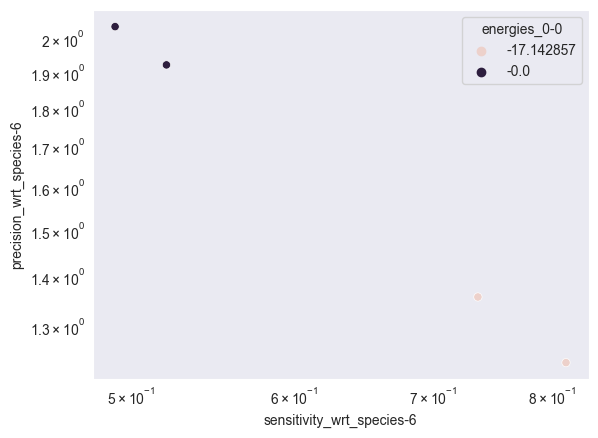

array([1.        , 0.5203516 , 0.49141315, 0.8121305 , 0.7362051 ])

In [28]:
sns.set_style('dark')
sns.scatterplot(strong_info[strong_info['sample_name'] != config['signal']['inputs'][0]], 
                x='sensitivity_wrt_species-6', y='precision_wrt_species-6', 
                hue=get_true_interaction_cols(strong_info, 'energies')[0])
plt.xscale('log')
plt.yscale('log')
plt.show()

strong_info['sensitivity_wrt_species-6'].unique()

In [29]:
print(strong_info['sensitivity_wrt_species-6'].unique())
print(strong_info['precision_wrt_species-6'].unique())


[1.         0.5203516  0.49141315 0.8121305  0.7362051 ]
[1.        1.9217776 2.0349476 1.2313292 1.3583171]


In [30]:
strong_info[get_true_interaction_cols(strong_info, 'energies')]

,energies_0-0,energies_0-1,energies_0-2,energies_1-0,energies_1-1,energies_1-2,energies_2-0,energies_2-1,energies_2-2
0,-0.000000,-0.0,-0.0,-0.0,-15.0,-0.000000,-0.0,-0.000000,-25.0
1,-0.000000,-0.0,-0.0,-0.0,-15.0,-0.000000,-0.0,-0.000000,-25.0
2,-0.000000,-0.0,-0.0,-0.0,-15.0,-0.000000,-0.0,-0.000000,-25.0
3,-17.142857,-0.0,-0.0,-0.0,-15.0,-17.142857,-0.0,-17.142857,-25.0
4,-17.142857,-0.0,-0.0,-0.0,-15.0,-17.142857,-0.0,-17.142857,-25.0
5,-17.142857,-0.0,-0.0,-0.0,-15.0,-17.142857,-0.0,-17.142857,-25.0


In [31]:
strong_info[get_true_interaction_cols(strong_info, 'binding_rates_dissociation')]

,binding_rates_dissociation_0-0,binding_rates_dissociation_0-1,binding_rates_dissociation_0-2,binding_rates_dissociation_1-0,binding_rates_dissociation_1-1,binding_rates_dissociation_1-2,binding_rates_dissociation_2-0,binding_rates_dissociation_2-1,binding_rates_dissociation_2-2
0,12.493034,12.493034,12.493034,12.493034,3.782161,12.493034,12.493034,12.493034,1.705545
1,12.493034,12.493034,12.493034,12.493034,3.782161,12.493034,12.493034,12.493034,1.705545
2,12.493034,12.493034,12.493034,12.493034,3.782161,12.493034,12.493034,12.493034,1.705545
3,3.188725,12.493034,12.493034,12.493034,3.782161,3.188725,12.493034,3.188725,1.705545
4,3.188725,12.493034,12.493034,12.493034,3.782161,3.188725,12.493034,3.188725,1.705545
5,3.188725,12.493034,12.493034,12.493034,3.782161,3.188725,12.493034,3.188725,1.705545


In [32]:
strong_info.drop(columns=get_true_interaction_cols(strong_info, 'binding_sites')).groupby(['sensitivity_wrt_species-6']).agg('mean', 'std')

,mutation_num,path_to_template_circuit,num_interacting,num_self_interacting,binding_rates_dissociation_0-0,binding_rates_dissociation_0-1,binding_rates_dissociation_0-2,binding_rates_dissociation_1-0,binding_rates_dissociation_1-1,binding_rates_dissociation_1-2,...,overshoot_diff_to_base_circuit,RMSE_diff_to_base_circuit,steady_states_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base
sensitivity_wrt_species-6,,,,,,,,,,,,,,,,,,,,,
0.491413,0.0,NaN,0.0,0.0,12.493034,12.493034,12.493034,12.493034,3.782161,12.493034,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0
0.520352,0.0,NaN,0.0,0.0,12.493034,12.493034,12.493034,12.493034,3.782161,12.493034,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0
0.736205,0.0,NaN,0.0,0.0,3.188725,12.493034,12.493034,12.493034,3.782161,3.188725,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0
0.812130,0.0,NaN,0.0,0.0,3.188725,12.493034,12.493034,12.493034,3.782161,3.188725,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0
1.000000,0.0,NaN,0.0,0.0,7.840879,12.493034,12.493034,12.493034,3.782161,7.840879,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


In [33]:
strong_info['initial_steady_states'].unique()

array([48.928616, 33.61822 , 25.02562 , 32.602623, 31.239254, 23.233873])